# 2. 点操作

点操作顾名思义，就是针对像素点级的操作，也可以叫灰度变换(intensity transform)，点操作虽然是数字图像处理中最简单的操作，但是也是应用最多最广泛的操作，在很多场景中点操作往往有很显著的效果。另外，一些点操作通常是图像预处理的重要步骤，特别在深度学习的图像增广中起着举足轻重的作用，学习好点操作不仅是学习数字图像处理的第一步，也是深度学习计算机视觉的基础。点操作主要分为单图片点操作和组合图片点操作，单图片点操作的公式如下：

$$s = T(r)$$

其中，$r$为源像素点灰度值，$s$为目标像素点灰度值，$T$为变换函数。需要注意的是，我们需要对源图像的所有像素点都进行$T$操作后才能得到目标图像。

组合图片点操作公式如下：

$$s = T(r_1, r_2, \cdots, r_n)$$

其中，$r_1$为源图像1的像素点灰度值，$r_2$为源图像2的像素点灰度值，$r_n$为源图像n的像素点灰度值，$s$为目标像素点灰度值，$T$为变换函数，所以组合图像点操作就是将n个图片的像素点组合起来进行$T$操作，最后得到目标图像。

## 2.1 单图片点操作

我们主要介绍四种单图片点操作:图像反转、线性变换、对数变换、伽马变换和分段线性变换

### 2.1.1 图像反转

图像反转公式如下：

$$s = T(r) = L - 1 - r$$

其中L为灰度级，由于我们通常用八位无符号整型存储图像，所以L = 256，并且由公式可以知道$s \in [0, 255]$。

In [1]:
import cv2
import numpy as np

r = cv2.imread('./images/gray.jpg')
s = 255 - r
cv2.imshow('origin', r)
cv2.imshow('destination', s)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 2.1.2 线性变换

图像线性变换公式如下：

$$s = T(r) = a\times r + b$$

其中$a$为缩放因子，$b$为位移因子。由之前的学习我们知道，灰度值越大越接近白色，越小越接近黑色，如果图像整体灰度值偏大则图片偏亮，反之图像偏暗，所以我们可以用线性变换调整图像整体的亮度。

In [2]:
def LinearTransform(r, a, b):
    s = a*r + b
    s = np.clip(s, 0, 255)
    return np.uint8(s)

s = LinearTransform(r, 1.2, 20)
cv2.imshow('origin', r)
cv2.imshow('destination', s)
cv2.waitKey(0)
cv2.destroyAllWindows()

**注意1：线性变换后的灰度值可能大于255，也可能小于0，我们一般将大于255的灰度值置为255，小于0的则置零，否则会出现下面的情况：**

In [3]:
def LinearTransform(r, a, b):
    s = a*r + b
    return np.uint8(s)

s = LinearTransform(r, 1.2, 20)
cv2.imshow('origin', r)
cv2.imshow('destination', s)
cv2.waitKey(0)
cv2.destroyAllWindows()

可以看到，一些本该是很亮的区域反而变暗，这是因为这些像素点的灰度值大于255，而当我们转化为uint8时会发生截断，如270的二进制为1 0000 1110，转换时只会取低八位，即0000 1110，也就是十进制的14.

**注意2：需要将最后的图像转化为uint8，否则会出现下面的情况：**

In [4]:
def LinearTransform(r, a, b):
    s = a*r + b
    s = np.clip(s, 0, 255)
    return s

s = LinearTransform(r, 1.2, 20)
cv2.imshow('origin', r)
cv2.imshow('destination', s)
cv2.waitKey(0)
cv2.destroyAllWindows()

上面的两点注意虽然很简单，但是是很多入门者经常会犯的错误，希望读者在后面的学习中能够时常注意这两点。

### 2.1.3 对数变换

虽然线性变换能在一定程度上调整亮度，但是为了确保输出值在0到255之间，我们最后会将大于255的灰度值置为255，将小于0的灰度值置零，这会导致一些灰度信息丢失，失去了原本图像中的一些特征。对数变换可以将图像的低灰度值部分扩展，显示出低灰度部分更多的细节，将其高灰度值部分压缩，减少高灰度值部分的细节，从而达到强调图像低灰度部分的目的，也就是可以将整体图像变亮，并且对数变换后的灰度值范围仍是0到255，在一定程度上保全了原图的特征。对数变换的公式如下：

$$s = 255 \times c \cdot log_{v+1}(1 + v\cdot \frac{r}{255})$$

其中v是对数变换的主要参数，v越大效果越明显，c为常数，通常为1。由上式我们也可以看出，该函数的定义域和值域都是$[0, 255]$，所以我们不用像线性变换一样担心数值溢出的问题。

对数变换的反函数就对应反对数变换，相应的，反对数函数更强调图像高灰度部分，其作用就是将整体图像变暗。反对数变换的公式如下：

$$s = 255 \times c \cdot \frac{(v+1)^{\frac{r}{255}} - 1}{v}$$

下图是当$c=1$时，对数变换和反对数变换的函数图像：

<center><img src="images/log.jpg" width="30%" ></center>

由函数图像我们就能很容易地看出对数变换可以调整亮度的原因，以$v = 50$为例，首先我们可以知道，当$\frac{r}{255}$属于$(0, 1)$时，对数变换函数都在$y = x$之上，这说明对数变换后的灰度值都大于原本灰度值。其次，当$\frac{r}{255}$属于$[0, 0.2]$时，$\frac{s}{255}$大致属于$[0, 0.6]$，这就说明对数变换更强调低灰度部分，而压缩了高灰度部分。从上图还能看出v越大，对低灰度部分的扩展就越强，对高灰度部分的压缩也就越强。

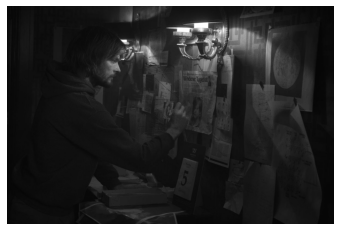

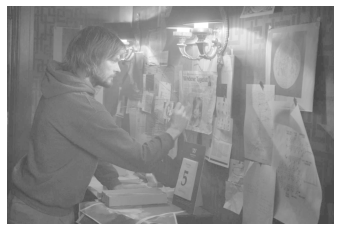

In [5]:
from matplotlib import pyplot as plt

img = cv2.imread('./images/dark.jpg', 0)  # 这里是对灰度图像进行操作，当然也可以对彩色图像进行对数变换
dest = np.zeros_like(img)
cv2.intensity_transform.logTransform(img, dest)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(dest, cmap='gray')
plt.axis('off')
plt.show()

## 2.1.4 伽马变换

伽马变换公式如下：

$$s = 255 \times c \cdot (\frac{r}{255})^\gamma$$

<center><img src="images/gamma.jpg" width="30%" ></center>

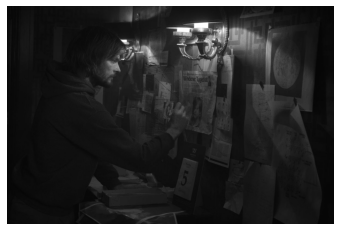

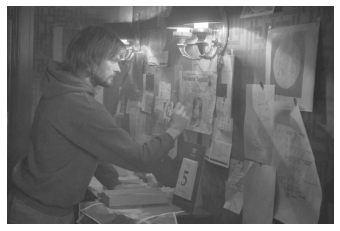

In [6]:
import cv2
import numpy as np

dest = np.zeros_like(img)
cv2.intensity_transform.gammaCorrection(img, dest, 0.3)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(dest, cmap='gray')
plt.axis('off')
plt.show()

### 2.1.5 分段线性变换

**对比度拉伸**

对比度拉伸的函数图像如下所示：

<center><img src="images/piecewise_linear1.jpg" width="30%" ></center>

图像中标注出的两个点称为为控制点，根据这两个点的坐标和点(0, 0)和点(1,1)我们可以唯一地确定一个分段函数，通过调整两个控制点我们可以对图像的对比度进行调整，比如下图（左）整体偏亮，我们可以突出低灰度部分，抑制高灰度部分来使图像的灰度分布更加平衡。灰度拉伸的结果如下图（右）所示，可以看到效果比较明显。

<center><img src="./images/contrast_strenching.jpg" width="60%" ></center>

**灰度切片**

灰度切片也是分段线性函数的一种，它的目的主要是提取我们感兴趣的灰度区间，针对不同的应用场景，可以构造下列三种函数：

<center><img src="images/piecewise_linear2.jpg" width="30%" ></center>

这个函数的目的是将感兴趣的灰度区间置为255，不感兴趣的区间置为0，例如控制点为$(x_{1}, 255)$和$(x_{2}, 255)$，则将灰度为[0, x1]和[x2, 255]的像素点灰度值置零，灰度为[x1, x2]的像素点灰度值置255，输出的图像是一张只有0和255的二值图。

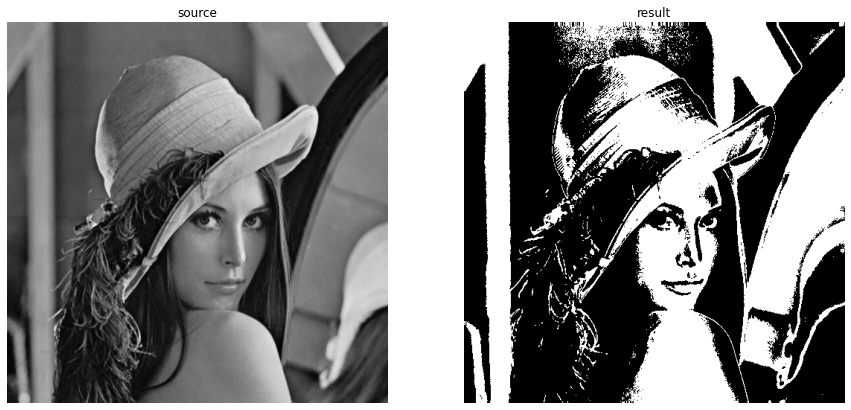

In [7]:
def intensity_slice1(x, x1, x2):
    x, x1, x2 = x / 255, x1 / 255, x2 / 255
    y = np.zeros_like(x)  
    y[(x >= 0) & (x < x1)] = 0
    y[(x >= x1) & (x < x2)] = 1
    y[x >= x2] = 0
    return np.uint8(255 * y)

img = cv2.imread('./images/lena.tif', 0)
dest = intensity_slice1(img, 110, 190)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('source')
plt.axis('off')
plt.subplot(122)
plt.imshow(dest, cmap='gray')
plt.title('result')
plt.axis('off')
plt.show()

<center><img src="images/piecewise_linear3.jpg" width="30%" ></center>

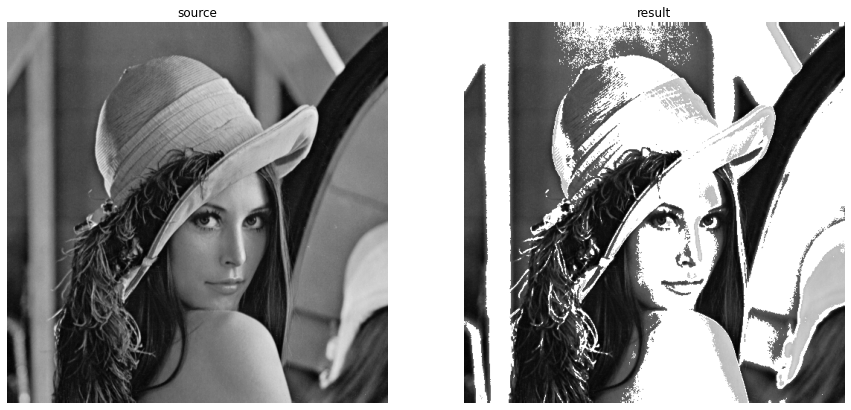

In [8]:
def intensity_slice2(x, x1, x2):
    y, x1, x2 = x / 255, x1 / 255, x2 / 255
    y[(y >= x1) & (y < x2)] = 1
    return np.uint8(255 * y)

img = cv2.imread('./images/lena.tif', 0)
dest = intensity_slice2(img, 110, 190)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('source')
plt.axis('off')
plt.subplot(122)
plt.imshow(dest, cmap='gray')
plt.title('result')
plt.axis('off')
plt.show()

<center><img src="images/piecewise_linear4.jpg" width="30%" ></center>

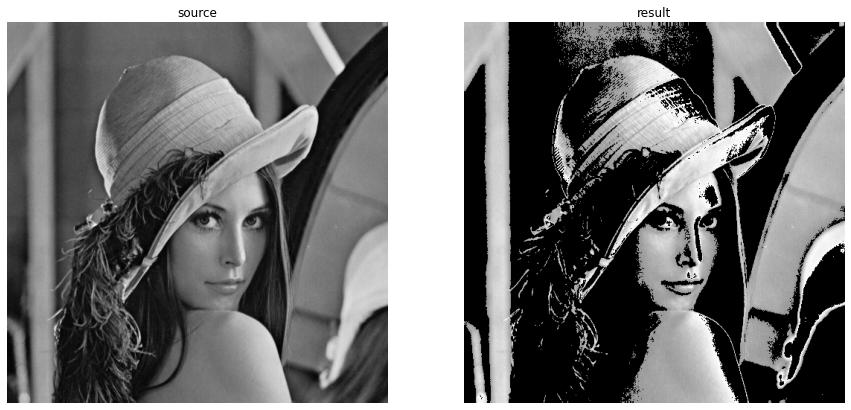

In [9]:
def intensity_slice2(x, x1, x2):
    x, x1, x2 = x / 255, x1 / 255, x2 / 255
    y = np.zeros_like(x)  
    y[(x >= 0) & (x < x1)] = 0
    y[(x >= x1) & (x < x2)] = x[(x >= x1) & (x < x2)]
    y[x >= x2] = 0
    return np.uint8(255 * y)

img = cv2.imread('./images/lena.tif', 0)
dest = intensity_slice2(img, 110, 190)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('source')
plt.axis('off')
plt.subplot(122)
plt.imshow(dest, cmap='gray')
plt.title('result')
plt.axis('off')
plt.show()

上面就是单图片点操作的相关内容，当然，点操作不止于此，读者可以基于这些变换，通过自己的应用场景来设计相应的变换函数。

## 2.2 组合图像点操作

在做组合图像点操作前，为了使组合图片有一一对应的像素点，我们需要**先将要进行操作的图像缩放到一个大小**，然后再对每一个像素进行操作。

### 2.2.1 图像加法

图像加法的主要目的是将两张图片进行混合，计算机视觉图像增广中的mixup方法基本原理就是图像加法。mixup变换公式如下：

$$s = \lambda \cdot r_1 + (1-\lambda) \cdot r_2$$

其中$\lambda$控制输出图像中$r_1$所占的成分，下面以cifar10数据集中的两张图片为例：

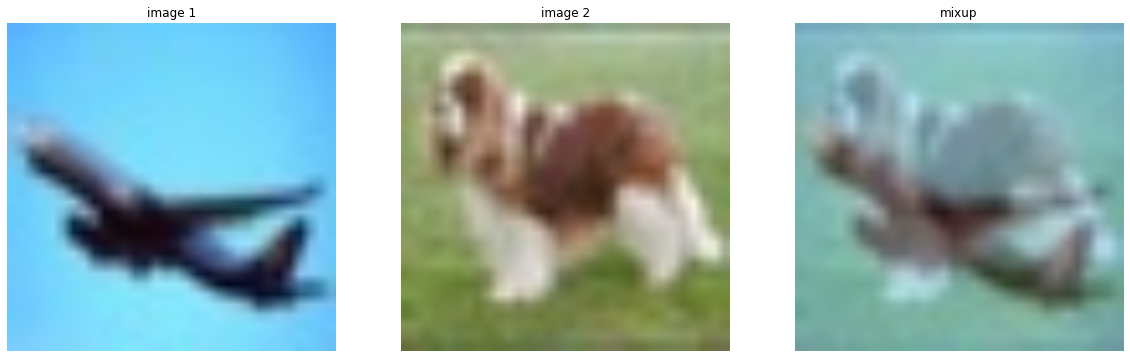

In [10]:
img1 = cv2.imread('./images/aeroplane_s_000037.jpg')
img2 = cv2.imread('./images/blenheim_spaniel_s_00006.jpg')
img1, img2 = cv2.resize(img1, (500, 500)), cv2.resize(img2, (500, 500))  # 将两张图像缩放到一个大小
lam = 0.5 
img = lam * img1 + (1 - lam) * img2
img = img.astype(np.uint8)
fig, ax = plt.subplots(1, 3, figsize=(20,20))
for i, j, name in zip(ax, [img1, img2, img], ['image 1', 'image 2', 'mixup']):
    i.imshow(j[:, :, ::-1])
    i.axis('off')
    i.set_title(name)
plt.show()

### 2.2.2 图像减法

图像减法主要作用是找出两张图片的区别，经常应用于简单的医学影像和异常检测，需要注意的是，我们通常对相减完后的图像取绝对值，而不是简单的截断操作（大于255取255，小于零取零），因为对于小于零的像素值其实也代表输入图像之间存在差别。

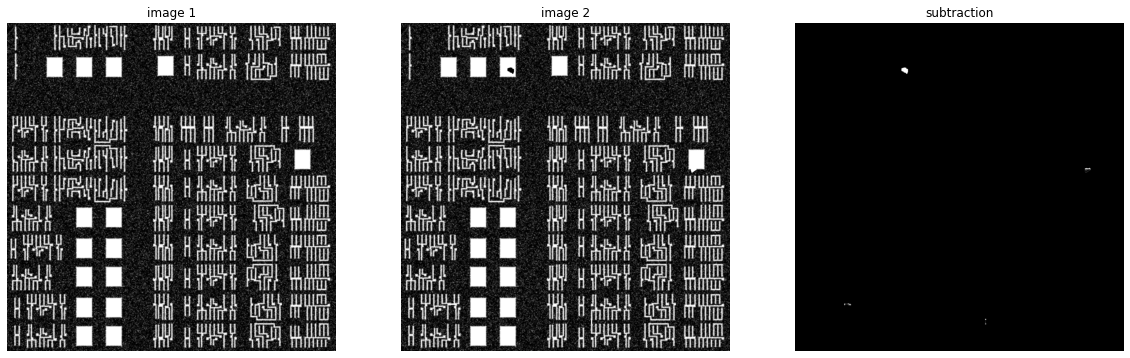

In [11]:
img1 = cv2.imread('./images/mask1.png', 0)
img2 = cv2.imread('./images/mask2.png', 0)
img = abs(img1 - img2)
fig, ax = plt.subplots(1, 3, figsize=(20,20))
for i, j, name in zip(ax, [img1, img2, img], ['image 1', 'image 2', 'subtraction']):
    i.imshow(j, cmap='gray')
    i.axis('off')
    i.set_title(name)
plt.show()

### 2.2.3 图像与

逻辑操作“与”在应用也较多，在图像分割领域可以用于取出原图对应mask的区域。

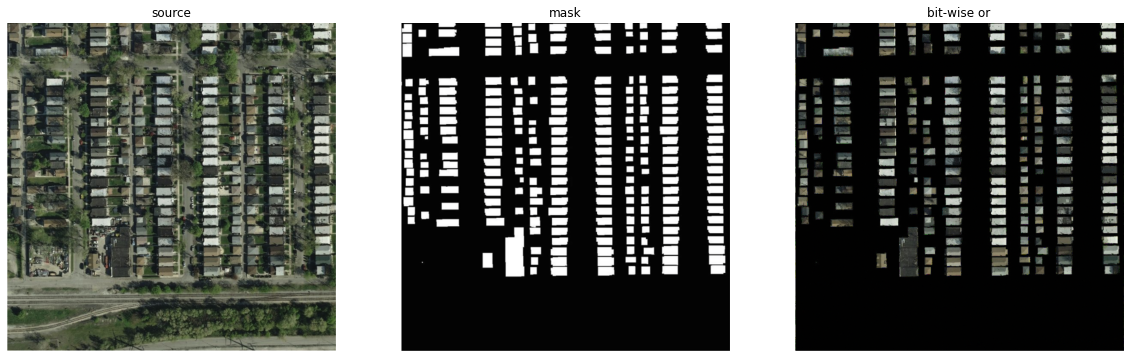

In [12]:
img1 = cv2.imread('./images/source.png', 1)
img2 = cv2.imread('./images/mask.png', 1)
img = img1 & img2
fig, ax = plt.subplots(1, 3, figsize=(20,20))
for i, j, name in zip(ax, [img1, img2, img], ['source', 'mask', 'bit-wise or']):
    i.imshow(j[:, :, ::-1])
    i.axis('off')
    i.set_title(name)
plt.show()

对于乘法和除法还有逻辑或操作大致原理与上述操作一直，这里便不再赘述，同样地，根据不同的应用场景，读者可以设计自己的组合图像函数，例如对于图像减法，我们可以考虑设定一个阈值，并且使用均方误差来评估两张图片的差异，如果均方误差超过该阈值，则认为有区别，否则则认为无区别。当然，我们可以不用局限于两张图像的操作，在图像去噪领域，通常会用多张图像求均值的操作来抑制随机噪声。

课后作业：

1. 实现对数变换和伽马变换

2. 对比度拉伸

注意：要生成一个zeros_like的矩阵

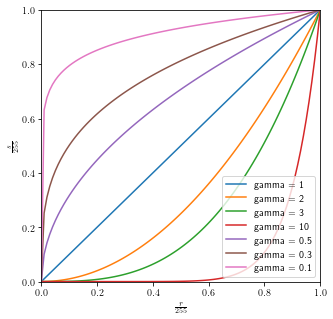

In [13]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plt.figure(figsize=(5, 5))
x = np.linspace(0, 1, 100)
gamma = 1
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 2
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 3
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 10
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 0.5
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 0.3
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
gamma = 0.1
plt.plot(x, x **gamma, label=f'gamma = {gamma}')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$\frac{r}{255}$')
plt.ylabel(r'$\frac{s}{255}$')
plt.legend()
plt.savefig('./images/gamma.jpg', dpi=1000)

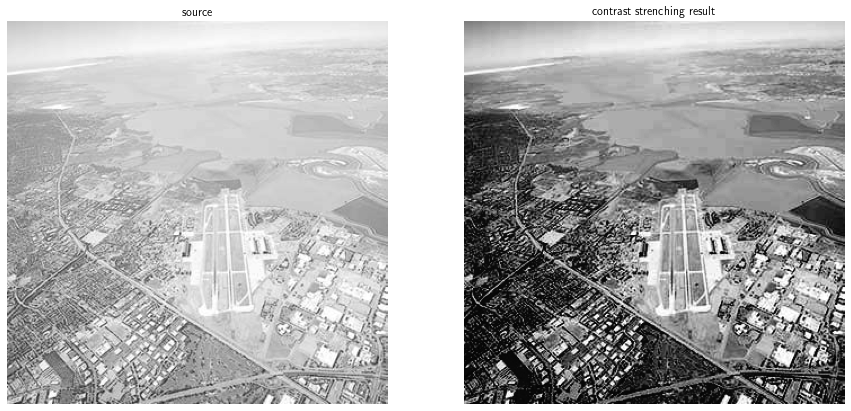

In [14]:
def piecewise_linear_trans(x, control_point1, control_point2):
    x1, y1, x2, y2 = *control_point1, *control_point2
    x = x / 255
    y = np.zeros_like(x)
    y[(x >= 0) & (x < x1)] = y1 / x1 * x[(x >= 0) & (x < x1)]
    y[(x >= x1) & (x < x2)] = (y2-y1) / (x2-x1) * (x[(x >= x1) & (x < x2)] - x1) + y1
    y[x >= x2] = (1-y2) / (1-x2) * (x[x >= x2]-1) + 1
    return np.uint8(255 * y)

img = cv2.imread('./images/city.tif', 0)
dest = piecewise_linear_trans(img, (0.6, 0.05), (0.9, 0.8))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('source')
plt.axis('off')
plt.subplot(122)
plt.imshow(dest, cmap='gray')
plt.title('contrast strenching result')
plt.axis('off')
# plt.savefig('./images/contrast_strenching.jpg', dpi=1000)
plt.show()

# 3 直方图操作

## 3.1 灰度直方图的定义与意义

灰度直方图顾名思义，就是统计图像每一个灰度值出现的频数，一幅L级灰度数字图像的灰度直方图可以定义如下：

$$h(r_k) = n_k, \ \ k = 0,1,2, \cdots, L-1$$

其中$n_k$表示第$k$个灰度出现的频数。下面以一张256级灰度的图像为例：

$$ \left( \begin{matrix} 99 & 24 & 24 & 56 & 24 \\ 234 & 180 & 234 & 180 & 24 \\ 0 & 0 & 0 & 255 & 255 \\ 128 & 99 & 24 & 24 & 0 \end{matrix} \right)$$

通过统计灰度频数我们可以得出：$h(r_0) = 4, h(r_24) = 6 \cdots, h(r_255) = 2$，其余的灰度值的频数都为零，根据此定义我们就可以画出一张图片的灰度直方图。

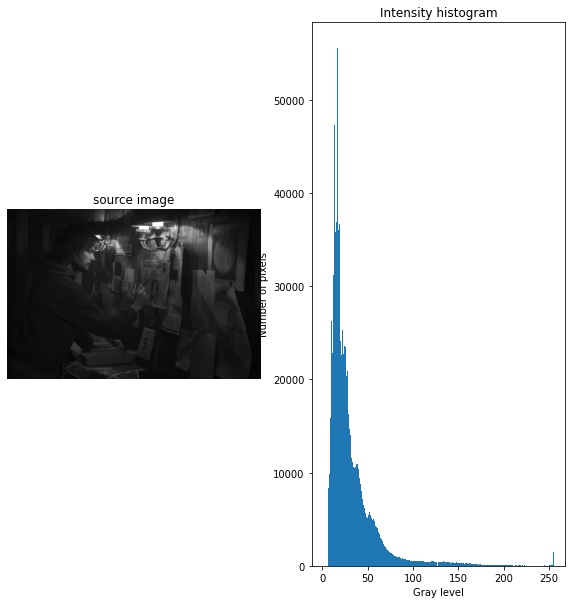

In [31]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('./images/dark.jpg', 0)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('source image')
plt.subplot(122)
plt.xlabel('Gray level')
plt.ylabel('Number of pixels')
plt.hist(img.flatten(), 256)
plt.title('Intensity histogram')
plt.show()

上面介绍的灰度直方图纵坐标为频数，称为非归一化直方图，与此对应的是归一化直方图，归一化直方图的纵坐标为频率，定义如下：

$$p(r_k) = \frac{n_k}{MN}, \ \ k = 0,1,2, \cdots, L-1$$

其中$MN$为图像的总像素数。

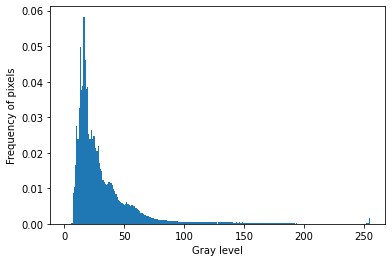

In [14]:
plt.xlabel('Gray level')
plt.ylabel('Frequency of pixels')
plt.hist(img.flatten(), 256, density=True,)
plt.show()

通过灰度直方图我们可以大致分析出图像灰度值的分布，以上面的直方图为例我们可以发现，大部分的像素分布在低灰度值部分，这导致图像整体偏暗，而一幅对比度高的图像的灰度值往往分布均匀。另外一个值得注意的细节是，通过图像我们可以得出直方图，但是知道直方图并不能推出原图，原因是直方图只包含了灰度信息，并没有包含像素点的位置信息。

## 3.2 直方图操作

直方图操作的公式与点操作形式相同：

$$s = T(r)$$

其中$s$是输出灰度值，$r$是输入灰度值，$T$是变换函数。但是，这里的$T$需要满足单调递增的条件，即当$r_1 > r_2$时，$s_1 > s_2$，$T$为单调递增函数主要有下列两个作用：

a) 由高数知识我们知道，单调函数必有反函数，所以$r = T^{-1}(s)$

b) 增函数则可以保证输出灰度值总是大于输入灰度值，避免产生伪影。

## 3.3 直方图归一化

一些偏亮或者偏暗的图片，灰度值往往没有分布在[0,255]内，而是分布在 [0,255] 的子区间内。我们可以通过直方图归一化的方式，将它的像素分布从 [0,255] 的子区间变为 [0,255] 范围内，从而提高图像的对比度。例如一张图片的灰度值范围为[a, b]，则直方图归一化的公式如下：

$$s = 255 \times \frac{r - a}{b-a}$$

In [50]:
img = cv2.imread('./images/normalization.jpg', 0)
dst = img.astype(float)
dst = 255 * (dst - dst.min()) / (dst.max() - dst.min())  # 直方图归一化
dst = dst.astype(np.uint8)

cv2.imshow('src', img)
cv2.imshow('dst', dst)
cv2.waitKey(-1)
cv2.destroyAllWindows()

可以看到直方图归一化后的图像比源图像偏亮，但是不是很明显，这也是直方图归一化的问题之一，下面我们从直方图来探讨问题出现的原因。

源图像灰度值范围：[3, 165]


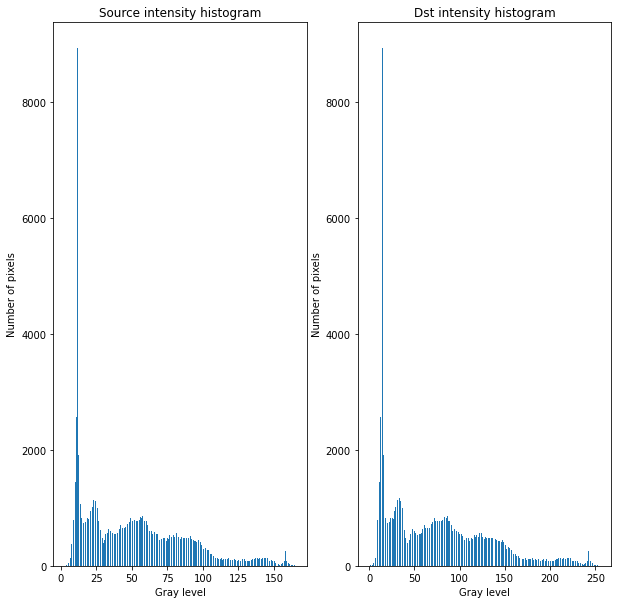

In [59]:
print(f'源图像灰度值范围：[{img.min()}, {img.max()}]')
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.xlabel('Gray level')
plt.ylabel('Number of pixels')
plt.hist(img.flatten(), 256)
plt.title('Source intensity histogram')
plt.subplot(122)
plt.xlabel('Gray level')
plt.ylabel('Number of pixels')
plt.hist(dst.flatten(), 256)
plt.title('Dst intensity histogram')
plt.show()

由直方图可以发现，经过直方图归一化后，灰度范围由[3, 165]变为[0, 255]，然而，整体图像的灰度分布却没有改变，大部分灰度值仍然分布在低灰度区域，这也是导致直方图归一化效果不好的主要原因。另外，对于一些灰度范围接近[0, 255]但是灰度分布极不均衡的图像，直方图归一化的效果微乎其微。

## 3.4 直方图均衡化

在之前的学习中我们已经知道偏亮图片和偏暗图片的灰度直方图，下面我们来看看对比度低图像的直方图：

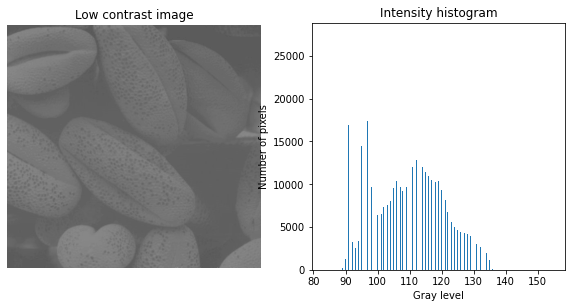

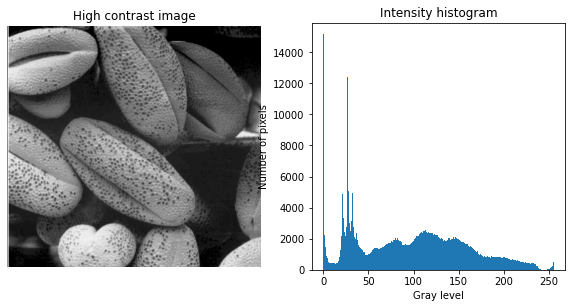

In [66]:
img = cv2.imread('./images/lowContrast.jpg', 0)
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('Low contrast image')
plt.subplot(222)
plt.xlabel('Gray level')
plt.ylabel('Number of pixels')
plt.hist(img.flatten(), 256)
plt.title('Intensity histogram')
plt.show()
img = cv2.imread('./images/highContrast.jpg', 0)
plt.figure(figsize=(10, 10))
plt.subplot(223)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('High contrast image')
plt.subplot(224)
plt.xlabel('Gray level')
plt.ylabel('Number of pixels')
plt.hist(img.flatten(), 256)
plt.title('Intensity histogram')
plt.show()

可以发现对比度较低的图像直方图分布较集中，一个典型的例子就是雾天拍摄的照片。相较而言，**对比度高的图像直方图分布较均匀，直方图均衡化就是根据这一特点，使图像的灰度直方图尽可能接近均匀分布**。直方图均衡化可以有效地调整灰度分布，使图像对比度增大，对对比度低、偏暗和偏亮图片都有很好的矫正作用。

在学习直方图均衡化之前，我们需要先复习一下均匀分布，下面是均匀分布的概率密度函数：

$$f(x) = \begin{cases} \frac{1}{b-a}, \ &a \leq x \leq b, \\ 0, \ &\text{others} \end{cases}$$

根据密度函数，我们可以通过积分算出概率（概率密度函数与x轴围成图形的面积），若$(c, d) \subset (a, b)$，则$P\{c \leq x \leq d\} = \int_{c}^{d}\frac{1}{b-a}dx$。同理，若$u$是一个变量，则$P\{x \leq u\} = \int_{a}^{u}\frac{1}{b-a}dx$。

有了这些前置知识，我们就可以研究直方图均衡化的原理了。首先，我们的目的是使输出图像的灰度直方图为均匀分布，则可以做出下面的假设：

$$p_s(s)=\begin{cases} \frac{1}{255}, \ &0 \leq x \leq 255, \\ 0, \ &\text{others} \end{cases}$$

首先我们需要证明一个定理：

$$p_s(s) = p_r(r) \cdot \frac{dr}{ds}$$

证明：

由3.2的定义可得，$S=T(r)$，$T$是一个单调递增的函数。假设$s=T(r)$，$v=T(w)$，如果$v<s$，由$T$单调递增可得：$w<r$。

$\Rightarrow P(v<s) = p(w<r)$

$\Rightarrow \int_{-\infty}^{s}p_s(v)dv = \int_{-\infty}^{r}p_r(w)dw$

$\Rightarrow (\int_{-\infty}^{s}p_s(v)dv)' = (\int_{-\infty}^{r}p_r(w)dw)'$

$\Rightarrow p_s(s)ds = p_r(r)dr$

$\Rightarrow p_s(s) = p_r(r)\frac{dr}{ds}$

证毕。

$p_s(s) = p_r(r) \cdot \frac{dr}{ds}$

$\Rightarrow p_r(r) \cdot \frac{dr}{ds} = \frac{1}{255}$

$\Rightarrow 255p_r(r) dr = ds$

$\Rightarrow s = T(r) = 255 \int^{r}_{0} p_r(w)dw = 255 \sum^{k}_{j=0}p_r(r_j) = 255\sum^{k}_{j=1}\frac{n_j}{MN} = \frac{255}{MN}\sum^k_{j=0}n_j$，其中$k=0, 1, \cdots ,255$

**直方图均衡化例子**：

<center><img src="images/HE.png" width="70%" ></center>

课后作业：

实现直方图均衡化